## Modeling Ecological Dynamics: The Lotka-Volterra Equations

This notebook models the classic predator-prey dynamics using the Lotka-Volterra equations. We will use the famous Hudson's Bay Company lynx and hare pelt data (1845-1935) to fit the model parameters and simulate the population cycles.

### 1. Setup: Importing Libraries

First, we import the necessary Python libraries for:
* **pandas:** Data manipulation and reading our CSV file.
* **matplotlib.pyplot:** Plotting and visualizing the data.
* **scipy.integrate.solve_ivp:** Solving the ordinary differential equations (ODEs).
* **scipy.optimize.least_squares:** Optimizing parameters to fit the model to the data.
* **numpy:** Numerical operations.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import numpy as np

### 2. Data Loading and Preprocessing

The original dataset is in a text file format with space-separated values. We'll read this file, assign the correct column names ('Year', 'Hare', 'Lynx'), and then save it as a CSV file (`LynxHare.csv`). This conversion makes it much easier to load into a pandas DataFrame for the rest of our analysis.

In [65]:
txt_file_path = './data/LynxHare.txt'
csv_file_path = './data/LynxHare.csv'

column_name = ['Year', 'Hare', 'Lynx']

try:
    data = pd.read_csv(
        txt_file_path,
        sep=r'\s+',
        header=None,
        names=column_name
    )

    data.to_csv(csv_file_path, index=False)
    print(f"Data successfully converted and saved to {csv_file_path}")
    
except FileNotFoundError:
    print(f"Error: The file {txt_file_path} was not found.")

Data successfully converted and saved to ./data/LynxHare.csv


### 3. Data Exploration

In [66]:
csv_file_path = './data/LynxHare.csv'
df = pd.read_csv(csv_file_path)
df.head()

,Year,Hare,Lynx
0,1845,19.58,30.09
1,1846,19.60,45.15
2,1847,19.61,49.15
3,1848,11.99,39.52
4,1849,28.04,21.23


In [67]:
df.isnull().sum()

Year    0
Hare    0
Lynx    0
dtype: int64

In [68]:
print(df.shape)

(91, 3)


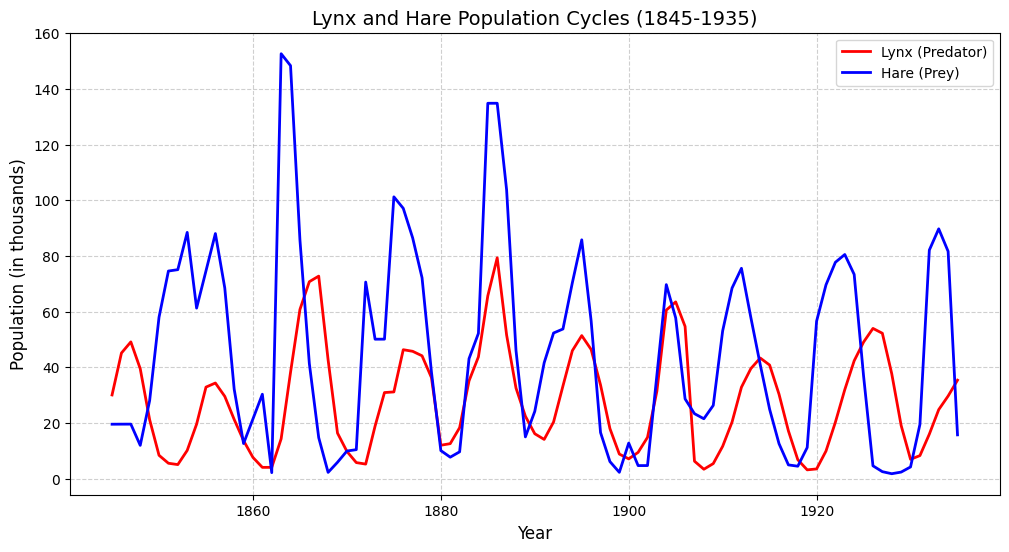

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['Year'], df['Lynx'],
        label='Lynx (Predator)',
         color='red',
         linewidth=2)

ax.plot(df['Year'], df['Hare'],
        label='Hare (Prey)',
         color='blue',
         linewidth=2)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Population (in thousands)', fontsize=12)
ax.set_title('Lynx and Hare Population Cycles (1845-1935)', fontsize=14)

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()


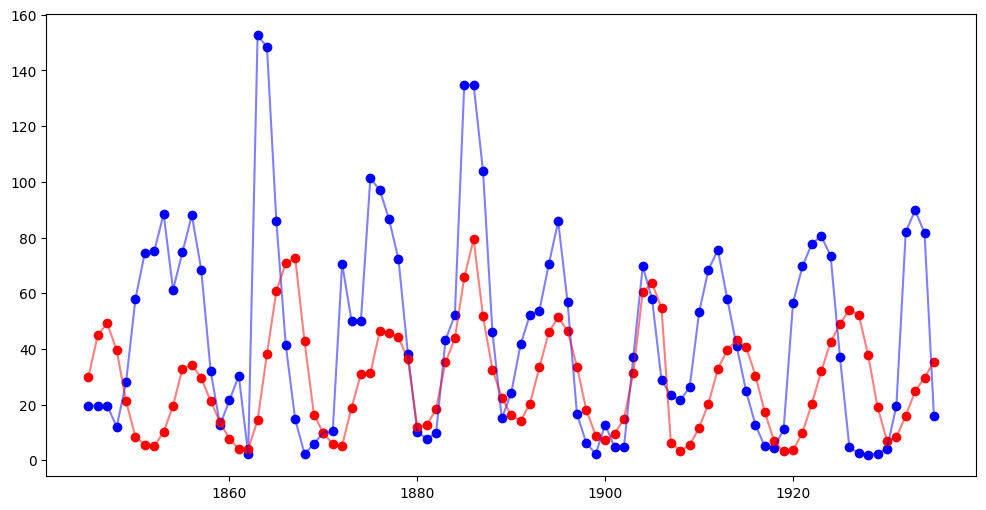

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['Year'], df['Hare'], label='Hare (Line)', color='blue', alpha=0.5)
ax.plot(df['Year'], df['Lynx'], label='Lynx (Line)', color='red', alpha=0.5)

ax.scatter(df['Year'], df['Hare'], label='Hare (Points)', color='blue')
ax.scatter(df['Year'], df['Lynx'], label='Lynx (Points)', color='red')

In [71]:
print(df.describe())

             Year        Hare       Lynx
count    91.00000   91.000000  91.000000
mean   1890.00000   45.406484  28.336593
std      26.41338   36.375402  18.864463
min    1845.00000    1.800000   3.190000
25%    1867.50000   12.730000  11.840000
50%    1890.00000   40.970000  29.590000
75%    1912.50000   71.405000  42.520000
max    1935.00000  152.650000  79.350000


### 4. Defining the Lotka-Volterra Model

This function defines the core mathematical model. It implements the two coupled ordinary differential equations (ODEs) of the Lotka-Volterra model:

1.  **Prey (Hare, `x`) Population:**
    `dxdt = (alpha * x) - (beta * x * y)`
    * `alpha * x`: Exponential growth of prey (proportional to its population).
    * `-beta * x * y`: Decrease in prey due to predation (proportional to the rate of encounters between prey and predators).

2.  **Predator (Lynx, `y`) Population:**
    `dydt = (delta * x * y) - (gamma * y)`
    * `delta * x * y`: Growth of predator population (proportional to the rate of encounters, scaled by `delta` for "food" conversion).
    * `-gamma * y`: Exponential decay of predators (natural death).

In [72]:
def lotka_volterra(t, y, alpha, beta, delta, gamma):
    x= y[0]
    y=y[1]

    dxdt = (alpha * x) - (beta * x * y)
    dydt = (delta * x * y) - (gamma * y)

    return [dxdt, dydt] 

### 5. Preparing Data and Defining the Cost Function

Before we can find the best parameters, we need to:
1.  Extract our data from the DataFrame into NumPy arrays (`t_points`, `Hare`, `Lynx`).
2.  Store the real populations in a single `data` array.
3.  Set the initial conditions (`y0`) for the simulation using the first data point from 1845.

Next, we define the `calculate_residuals` function. This is the "cost function" that `scipy.optimize.least_squares` will use. For any given set of parameters (`alpha`, `beta`, `delta`, `gamma`), it:
1.  Runs the `solve_ivp` simulator with those parameters.
2.  Calculates the difference (the "residual") between the simulated populations and the real `data`.
3.  Returns these errors as a flattened array for the optimizer to minimize.

In [ ]:
# Extracting the data frame to series
t_points = df['Year'].values
Hare = df['Hare'].values
Lynx = df['Lynx'].values

data = np.array([Hare, Lynx])

y0 = [Hare[0], Lynx[0]]

def calculate_residuals(params, t, data, y0_init):
    alpha, beta, delta, gamma = params

    sol = solve_ivp(
        lotka_volterra,             
        (t.min(), t.max()),         
        y0_init,                    
        args=(alpha, beta, delta, gamma), 
        t_eval=t
    )

    if not sol.success:
        return np.full(data.size, 1e9)
    
    simulated_populations = sol.y

    error = data - simulated_populations

    return error.flatten()

### 6. Parameter Fitting with `least_squares`

This is the optimization step. We use `scipy.optimize.least_squares` to find the set of parameters that minimizes the errors (residuals) returned by our `calculate_residuals` function.

* We provide an `initial_guess` for `[alpha, beta, delta, gamma]`.
* We pass our data (t, data, y0) as additional `args`.
* We set `bounds` to `(0, np.inf)` because population parameters cannot be negative.

The optimizer will then run the simulation many times, adjusting the parameters until it finds the values that create a simulated curve "closest" to the real data.

In [74]:
initial_guess = [1.1, 0.4, 0.1, 0.4]

fit_result = least_squares(
    calculate_residuals,
    initial_guess,
    args=(t_points, data, y0),
    bounds=(0, np.inf)
)

if fit_result.success:
    best_fit_params = fit_result.x
    print("alpha:", best_fit_params[0])
    print("beta:", best_fit_params[1])
    print("delta:", best_fit_params[2])
    print("gamma:", best_fit_params[3])
else:
    print("optimization failed")

alpha: 1.1972432316279809
beta: 0.20237562019893165
delta: 0.09136850799445048
gamma: 0.37680589781329293


### 7. Simulating with Optimal Parameters

Now that we have the optimized parameters in `best_fit_params`, we run the `solve_ivp` simulator one final time.

This generates the complete simulated population curves (`simulated_hare` and `simulated_lynx`) over the entire time period using the parameters that the `least_squares` optimizer determined were the "best fit" for the real data. These arrays will be used for plotting.

In [75]:
solve_best_fit = solve_ivp(
    lotka_volterra,
    (t_points.min(), t_points.max()),
    y0,
    args=tuple(best_fit_params),
    t_eval=t_points
)

simulated_hare = solve_best_fit.y[0]
simulated_lynx = solve_best_fit.y[1]

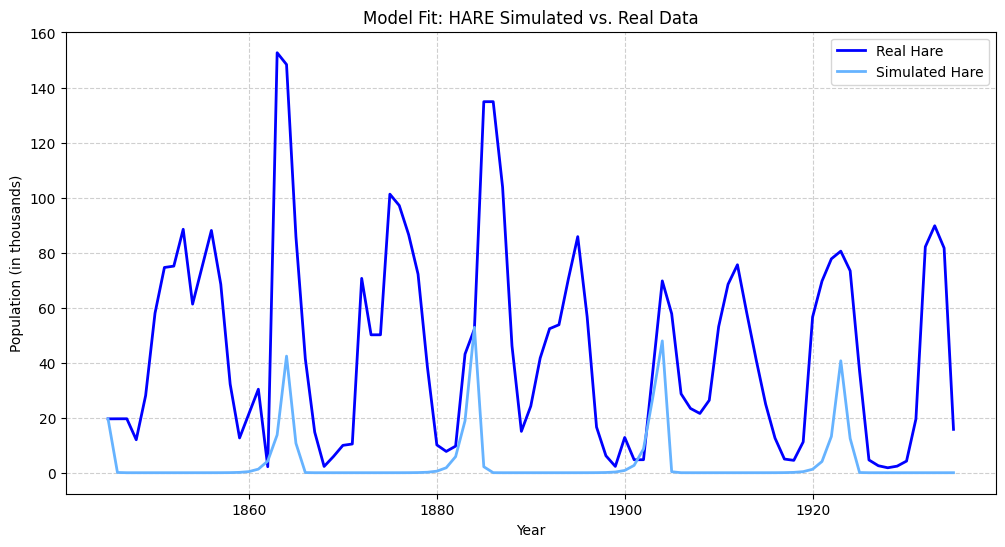

In [81]:
# Plotting Real Hare data and Simulated Hare data together

plt.figure(figsize=(12, 6))

plt.plot(t_points, Hare, 'b-', label='Real Hare', linewidth=2)
plt.plot(t_points, simulated_hare, color='#66b3ff', label='Simulated Hare', linewidth=2)

plt.xlabel('Year')
plt.ylabel('Population (in thousands)')
plt.title('Model Fit: HARE Simulated vs. Real Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

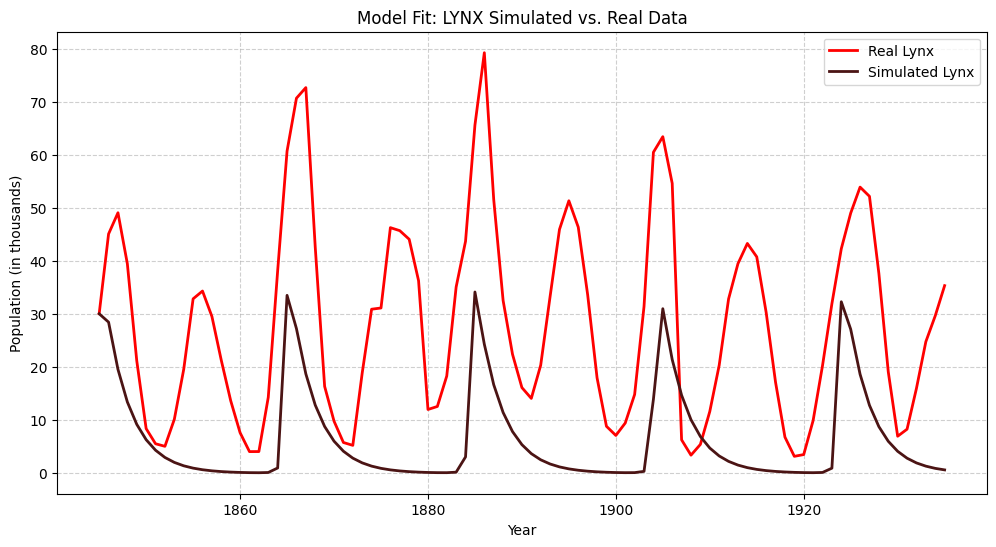

In [82]:
# Plotting Real Lynx data and Simulated Lynx data together

plt.figure(figsize=(12, 6))

plt.plot(t_points, Lynx, 'r-', label='Real Lynx', linewidth=2)
plt.plot(t_points, simulated_lynx, color="#4b1414", label='Simulated Lynx', linewidth=2)

plt.xlabel('Year')
plt.ylabel('Population (in thousands)')
plt.title('Model Fit: LYNX Simulated vs. Real Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 8. Analyzing the Model Fit (Cost & Residuals)

The `fit_result` object contains detailed statistics about how well the optimization performed. We can analyze the `cost` (the sum of the squares of the errors) and the `fun` attribute (the residuals, or errors, themselves) to get a numerical idea of the model's accuracy.

This cell prints:
* **Cost:** The final value of the least-squares cost function. A lower number indicates a better fit.
* **Average Error (Mean Residual):** The average amount (in thousands of pelts) by which the simulation was "off" from the real data.
* **Largest Single Error (Max Residual):** The biggest single deviation at any point in the 91-year period, which highlights the model's weakest point.

In [78]:
cost = fit_result.cost
print(f"Cost: {cost:.2f}")

residuals = fit_result.fun
print(f"Total number of error values: {len(residuals)}")
print(f"Average Error (Mean Residual): {np.mean(residuals):.2f}")
print(f"Median Error (Median Residual): {np.median(residuals):.2f}")
print(f"Largest Single Error (Max Residual): {np.max(np.abs(residuals)):.2f} (in thousands of pelts)")
print(f"This means at least one data point was {np.max(np.abs(residuals)):.2f}k units off from the simulation.")
print("\n")

Cost: 167321.40
Total number of error values: 182
Average Error (Mean Residual): 31.79
Median Error (Median Residual): 25.51
Largest Single Error (Max Residual): 138.91 (in thousands of pelts)
This means at least one data point was 138.91k units off from the simulation.




### 9. Analyzing the Model Fit (Percentage Error)

While the absolute residuals are useful, they don't give a great sense of the *relative* error. For example, being off by 10k pelts when the population is 20k is a huge error (50%), but being off by 10k when the population is 150k is a much smaller error (~7%).

To account for this, we calculate the **Mean Absolute Percentage Error (MAPE)**. This metric gives us the average error

In [79]:
epsilon = 1e-6 

mape_hare = np.mean(
    np.abs( (Hare - simulated_hare) / (Hare + epsilon) )
) * 100

mape_lynx = np.mean(
    np.abs( (Lynx - simulated_lynx) / (Lynx + epsilon) )
) * 100

print(f"--- Model 'Percentage Error' (MAPE) ---")
print(f"Mean Absolute Percentage Error (Hare):   {mape_hare:.2f} %")
print(f"Mean Absolute Percentage Error (Lynx):   {mape_lynx:.2f} %")

--- Model 'Percentage Error' (MAPE) ---
Mean Absolute Percentage Error (Hare):   91.94 %
Mean Absolute Percentage Error (Lynx):   80.80 %
